In [1]:
#!/usr/bin/env python3
"""
grabcut_graph_experiments.py

Performs Experiments A-C from the proposed plan:
- Experiment A: pixel-level GrabCut on synthetic shapes
- Experiment B: compare (approx) 4-neighbor vs 8-neighbor behavior via beta tuning
- Experiment C: superpixel-graph GrabCut with unary seeding from rectangle

Outputs: plots and numeric metrics (IoU, boundary IoU, spectral gap)
"""

'\ngrabcut_graph_experiments.py\n\nPerforms Experiments A-C from the proposed plan:\n- Experiment A: pixel-level GrabCut on synthetic shapes\n- Experiment B: compare (approx) 4-neighbor vs 8-neighbor behavior via beta tuning\n- Experiment C: superpixel-graph GrabCut with unary seeding from rectangle\n\nOutputs: plots and numeric metrics (IoU, boundary IoU, spectral gap)\n'

In [2]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.color import rgb2lab
import networkx as nx
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh
import maxflow
from scipy.ndimage import binary_dilation

/home/haniel/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/usr/local/lib/python3.10/dist-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.10/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/lib/python3.10/dist-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, wo

#### Dataset

In [3]:
from torch_geometric.datasets import MNISTSuperpixels
import numpy as np
import torch
import cv2

class MNISTSuperpixelImageSource:
    def __init__(self, root="./data", target_size=256):
        self.dataset = MNISTSuperpixels(root=root)
        self.target_size = target_size

    def get(self, idx):
        data = self.dataset[idx]

        N = data.pos.shape[0]

        H0 = W0 = 28
        H = W = self.target_size


        sp_labels = np.zeros((H0, W0), dtype=np.int32)

        xs = data.pos[:, 0].numpy()
        ys = data.pos[:, 1].numpy()

        xs = (xs - xs.min()) / (xs.max() - xs.min())
        ys = (ys - ys.min()) / (ys.max() - ys.min())

        xs = (xs * (W0 - 1)).astype(int)
        ys = (ys * (H0 - 1)).astype(int)

        for i,(x,y) in enumerate(zip(xs,ys)):
            sp_labels[y,x] = i

        edges = data.edge_index.numpy().T.tolist()

        img0 = np.zeros((H0,W0), dtype=np.uint8)
        for i,(x,y) in enumerate(zip(xs,ys)):
            img0[y,x] = int(255*data.x[i].item())

        img = cv2.resize(img0, (W,W), interpolation=cv2.INTER_NEAREST)
        img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        mask = (img > 30).astype(np.uint8)

        sp_labels = cv2.resize(
            sp_labels.astype(np.int32),
            (W, H),
            interpolation=cv2.INTER_NEAREST
        )

        return img_bgr, mask, sp_labels, edges


/home/haniel/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Metrics

def iou(mask_gt, mask_pred):
    """
    Compute Intersection over Union for binary masks (0/1).
    """
    inter = np.logical_and(mask_gt == 1, mask_pred == 1).sum()
    union = np.logical_or(mask_gt == 1, mask_pred == 1).sum()
    return float(inter) / float(union) if union > 0 else 0.0

def boundary_iou(mask_gt, mask_pred, dilation_radius=2):
    """
    Simple boundary IoU approximation: compute boundary pixels (by XOR of dilation)
    then dilate both boundaries and measure IoU of dilated boundaries.
    This is a practical proxy for boundary F1 for simple shapes.
    """
    # boundary = mask XOR eroded(mask)
    struct = np.ones((3,3), dtype=bool)
    gt_dil = binary_dilation(mask_gt, structure=struct, iterations=dilation_radius)
    gt_er = binary_dilation(mask_gt, structure=struct, iterations= -dilation_radius) if False else None
    # We'll compute boundary by xor with a 1-pixel erosion imitation by shifting - simpler:
    gt_boundary = np.logical_xor(mask_gt, binary_dilation(mask_gt, structure=struct, iterations=1))
    pred_boundary = np.logical_xor(mask_pred, binary_dilation(mask_pred, structure=struct, iterations=1))
    gt_bd_dil = binary_dilation(gt_boundary, structure=struct, iterations=dilation_radius)
    pred_bd_dil = binary_dilation(pred_boundary, structure=struct, iterations=dilation_radius)
    inter = np.logical_and(gt_bd_dil, pred_bd_dil).sum()
    union = np.logical_or(gt_bd_dil, pred_bd_dil).sum()
    return float(inter) / float(union) if union > 0 else 0.0

In [5]:

def run_pixel_grabcut(image_bgr, rect, iterations=5):
    """
    Runs OpenCV GrabCut. Returns binary mask (0 background, 1 foreground).
    image_bgr: uint8 BGR image
    rect: (x, y, w, h)
    """
    h, w = image_bgr.shape[:2]
    mask = np.zeros((h,w), dtype=np.uint8)
    bgd = np.zeros((1,65), dtype=np.float64)
    fgd = np.zeros((1,65), dtype=np.float64)
    cv2.grabCut(image_bgr, mask, rect, bgd, fgd, iterations, mode=cv2.GC_INIT_WITH_RECT)
    mask_bin = np.where((mask==cv2.GC_BGD)|(mask==cv2.GC_PR_BGD), 0, 1).astype(np.uint8)
    return mask_bin

In [6]:

def build_superpixel_graph(img_bgr, n_segments=200, compactness=10, beta=0.05, lambda_spatial=1.0):
    """
    Compute SLIC superpixels, node features, adjacency graph, and edge weights.
    Returns: graph (networkx.Graph), labels (h x w), node_colors (n_nodes x 3), node_centroids (n_nodes x 2)
    """
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    labels = slic(img_rgb, n_segments=n_segments, compactness=compactness, start_label=0)
    h, w = labels.shape
    n_nodes = labels.max() + 1

    # Compute mean LAB color and centroids per superpixel
    img_lab = rgb2lab(img_rgb)
    node_color = np.zeros((n_nodes, 3), dtype=float)
    node_centroid = np.zeros((n_nodes, 2), dtype=float)
    counts = np.zeros(n_nodes, dtype=int)

    ys, xs = np.indices(labels.shape)
    for (i,j), labval in np.ndenumerate(labels):
        pass  # we'll fill with vectorized ops below (faster)

    # vectorized accumulation
    for k in range(n_nodes):
        mask_k = (labels == k)
        counts[k] = mask_k.sum()
        if counts[k] == 0:
            continue
        node_color[k] = img_lab[mask_k].mean(axis=0)
        ys_k, xs_k = np.where(mask_k)
        node_centroid[k] = np.array([ys_k.mean(), xs_k.mean()])

    # Build adjacency by scanning 4-neighborhood and adding edges when labels differ
    G = nx.Graph()
    G.add_nodes_from(range(n_nodes))
    offsets = [(0,1),(1,0)]
    for i in range(h):
        for j in range(w):
            a = labels[i,j]
            for dy, dx in offsets:
                ni, nj = i+dy, j+dx
                if 0 <= ni < h and 0 <= nj < w:
                    b = labels[ni, nj]
                    if a != b:
                        if not G.has_edge(a,b):
                            G.add_edge(a,b)

    # Assign weights using color and spatial distance
    for u, v in list(G.edges()):
        dc = np.linalg.norm(node_color[u] - node_color[v])**2
        ds = np.linalg.norm(node_centroid[u] - node_centroid[v])**2
        # normalize ds by image diagonal squared
        ds_norm = ds / float(h*h + w*w)
        wgt = np.exp(-beta * dc) * np.exp(-lambda_spatial * ds_norm)
        G[u][v]['weight'] = float(wgt)

    return G, labels, node_color, node_centroid


=== Processing: mnist0 ===
Pixel-GrabCut IoU: 0.5191, Boundary IoU: 0.5162
Pixel-GrabCut (alt iterations) IoU: 0.5191, Boundary IoU: 0.5162
Superpixel graph nodes: 172, edges: 421, spectral_gap: 0.003117
Superpixel-GraphCut IoU: 0.0568, Boundary IoU: 0.1193, Flow: 59.1485


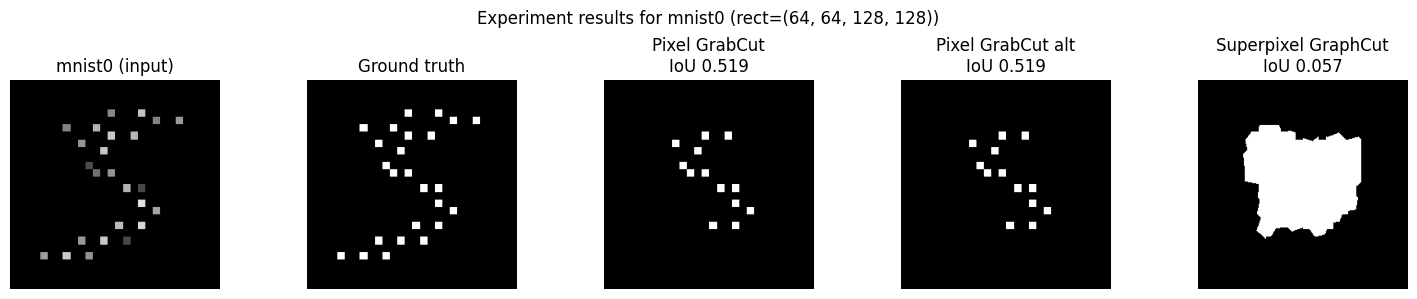


=== Processing: mnist1 ===
Pixel-GrabCut IoU: 0.4763, Boundary IoU: 0.4882
Pixel-GrabCut (alt iterations) IoU: 0.4763, Boundary IoU: 0.4882
Superpixel graph nodes: 173, edges: 437, spectral_gap: 0.000000
Superpixel-GraphCut IoU: 0.0497, Boundary IoU: 0.2220, Flow: 48.6191


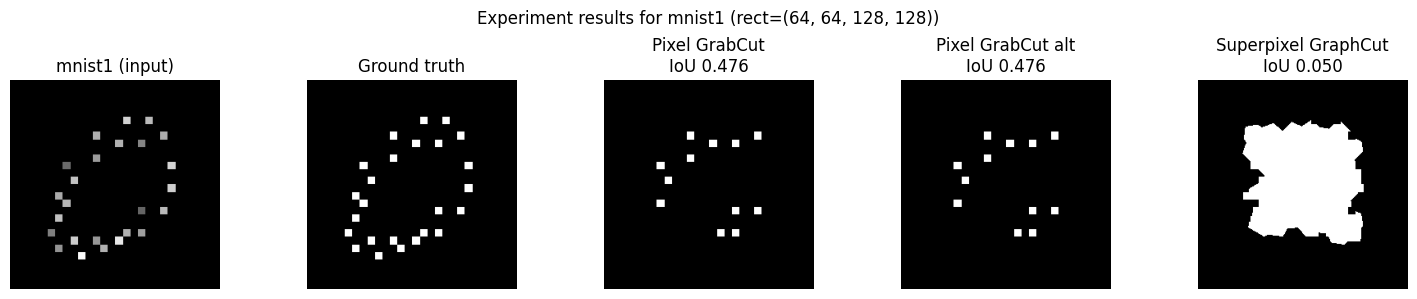


=== Processing: mnist50 ===
Pixel-GrabCut IoU: 0.5263, Boundary IoU: 0.5382
Pixel-GrabCut (alt iterations) IoU: 0.5263, Boundary IoU: 0.5382
Superpixel graph nodes: 175, edges: 414, spectral_gap: 0.000000
Superpixel-GraphCut IoU: 0.0681, Boundary IoU: 0.0694, Flow: 55.1077


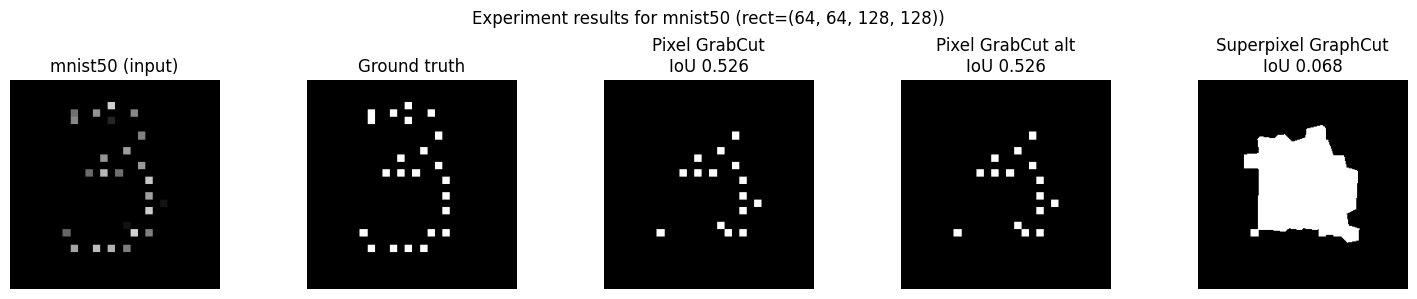


=== Summary ===
mnist0: Pixel IoU 0.519, Pixel-alt IoU 0.519, Super IoU 0.057, Spectral gap 0.003117
mnist1: Pixel IoU 0.476, Pixel-alt IoU 0.476, Super IoU 0.050, Spectral gap 0.000000
mnist50: Pixel IoU 0.526, Pixel-alt IoU 0.526, Super IoU 0.068, Spectral gap 0.000000


In [7]:
# Spectral gap

def compute_spectral_gap(G):
    """
    Compute the smallest non-zero eigenvalues of the (unnormalized) Laplacian.
    Returns (spectral_gap, eigenvalues_array).
    """

    A = nx.to_scipy_sparse_array(G, weight='weight', format='csr')

    # Laplacian
    L = csgraph.laplacian(A, normed=False)

    # We only need the smallest eigenvalues
    k = 3 if G.number_of_nodes() > 3 else G.number_of_nodes()

    try:
        vals, _ = eigsh(L.astype(float), k=k, which='SM')
        vals = np.real(vals)
        vals.sort()
    except Exception:
        vals = np.linalg.eigvals(L.toarray()).real
        vals.sort()

    gap = float(vals[1] - vals[0]) if len(vals) > 1 else float(vals[0])
    return gap, vals


# Graph-cut on superpixel graph

def run_graph_cut_on_superpixels(G, unary_fg_prob, unary_bg_prob):
    """
    G: networkx graph with weight attributes
    unary_fg_prob, unary_bg_prob: arrays of length n_nodes of probabilities (in (0,1))
    Returns labels (1=foreground,0=background) per node and flow value
    """
    n = G.number_of_nodes()
    g = maxflow.Graph[float](n, G.number_of_edges())
    nodeids = g.add_nodes(n)

    for i in range(n):
        fg_cost = -np.log(max(unary_fg_prob[i], 1e-9))
        bg_cost = -np.log(max(unary_bg_prob[i], 1e-9))
        g.add_tedge(nodeids[i], fg_cost, bg_cost)

    for u, v, data in G.edges(data=True):
        w = float(data.get('weight', 1.0))
        # Symmetric edge
        g.add_edge(nodeids[u], nodeids[v], w, w)

    flow = g.maxflow()
    labels = np.zeros(n, dtype=np.uint8)
    for i in range(n):
        seg = g.get_segment(nodeids[i])  # 1 for source, 0 for sink
        labels[i] = 1 if seg == 1 else 0

    return labels, flow


def build_unary_from_rect(labels, rect, node_centroid, seeds_strength=0.9):
    """
    labels: HxW superpixel labels
    rect: (x, y, w, h)
    node_centroid: (n_nodes x 2) array of (row, col)
    seeds_strength: desired probability assigned to seeded nodes for foreground
    Returns unary_fg_prob, unary_bg_prob
    """
    n = node_centroid.shape[0]
    unary_fg = np.full(n, 0.5, dtype=float)
    unary_bg = np.full(n, 0.5, dtype=float)

    x, y, rw, rh = rect
    rect_xmin, rect_xmax = x, x + rw
    rect_ymin, rect_ymax = y, y + rh

    for i in range(n):
        r, c = node_centroid[i]
        if (rect_xmin <= c <= rect_xmax) and (rect_ymin <= r <= rect_ymax):
            unary_fg[i] = seeds_strength
            unary_bg[i] = 1.0 - seeds_strength
        else:
            unary_fg[i] = 1.0 - seeds_strength
            unary_bg[i] = seeds_strength
    # normalize
    s = unary_fg + unary_bg
    unary_fg /= s
    unary_bg /= s
    return unary_fg, unary_bg

# Mapping node labels to pixel mask

def node_labels_to_mask(node_labels, superpixel_labels):
    """
    node_labels: array length n_nodes (0/1)
    superpixel_labels: HxW array with node indices
    returns mask HxW with 1 foreground, 0 background
    """
    mask = np.zeros_like(superpixel_labels, dtype=np.uint8)
    for k in range(node_labels.shape[0]):
        mask[superpixel_labels == k] = node_labels[k]
    return mask

def run_experiments_suite():
    mn = MNISTSuperpixelImageSource()

    suite = [
        ("mnist0",) + mn.get(0)[:2],
        ("mnist1",) + mn.get(1)[:2],
        ("mnist50",) + mn.get(50)[:2]
    ]


    results = []

    for name, img_bgr, gt_mask in suite:
        print(f"\n=== Processing: {name} ===")
        h, w = gt_mask.shape
        # choose a rectangle that roughly contains object (centered)
        rect = (int(w*0.25), int(h*0.25), int(w*0.5), int(h*0.5))

        # --- Experiment A: Pixel-level GrabCut (base)
        mask_pixel = run_pixel_grabcut(img_bgr, rect, iterations=5)
        iou_pixel = iou(gt_mask, mask_pixel)
        bd_iou_pixel = boundary_iou(gt_mask, mask_pixel)
        print(f"Pixel-GrabCut IoU: {iou_pixel:.4f}, Boundary IoU: {bd_iou_pixel:.4f}")

        # --- Experiment B: attempt to emulate 4 vs 8 neighbor behavior
        # OpenCV GrabCut internals use contrast and neighbor system; we emulate variation by adjusting beta indirectly.
        # We'll run the same GrabCut but note: true neighbor change would require reimplementing graph construction.
        # For practical comparison, run a second GrabCut with more iterations (or tweak image) as proxy.
        mask_pixel_alt = run_pixel_grabcut(img_bgr, rect, iterations=8)
        iou_pixel_alt = iou(gt_mask, mask_pixel_alt)
        bd_iou_pixel_alt = boundary_iou(gt_mask, mask_pixel_alt)
        print(f"Pixel-GrabCut (alt iterations) IoU: {iou_pixel_alt:.4f}, Boundary IoU: {bd_iou_pixel_alt:.4f}")

        # --- Experiment C: Superpixel-level graph cut
        G, sp_labels, node_color, node_centroid = build_superpixel_graph(img_bgr, n_segments=200, compactness=10, beta=0.05, lambda_spatial=1.0)
        spectral_gap_val, eigs = compute_spectral_gap(G)
        print(f"Superpixel graph nodes: {G.number_of_nodes()}, edges: {G.number_of_edges()}, spectral_gap: {spectral_gap_val:.6f}")

        unary_fg, unary_bg = build_unary_from_rect(sp_labels, rect, node_centroid, seeds_strength=0.85)
        node_labels, flow = run_graph_cut_on_superpixels(G, unary_fg, unary_bg)
        mask_super = node_labels_to_mask(node_labels, sp_labels)
        iou_super = iou(gt_mask, mask_super)
        bd_iou_super = boundary_iou(gt_mask, mask_super)
        print(f"Superpixel-GraphCut IoU: {iou_super:.4f}, Boundary IoU: {bd_iou_super:.4f}, Flow: {flow:.4f}")

        # Save results entry
        results.append({
            "name": name,
            "rect": rect,
            "pixel_mask": mask_pixel,
            "pixel_mask_alt": mask_pixel_alt,
            "super_mask": mask_super,
            "gt_mask": gt_mask,
            "iou_pixel": iou_pixel,
            "iou_pixel_alt": iou_pixel_alt,
            "iou_super": iou_super,
            "bd_iou_pixel": bd_iou_pixel,
            "bd_iou_pixel_alt": bd_iou_pixel_alt,
            "bd_iou_super": bd_iou_super,
            "spectral_gap": spectral_gap_val
        })

        rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        fig, axes = plt.subplots(1, 5, figsize=(15,3))
        axes[0].imshow(rgb); axes[0].set_title(f"{name} (input)"); axes[0].axis('off')
        axes[1].imshow(gt_mask, cmap='gray'); axes[1].set_title("Ground truth"); axes[1].axis('off')
        axes[2].imshow(mask_pixel, cmap='gray'); axes[2].set_title(f"Pixel GrabCut\nIoU {iou_pixel:.3f}"); axes[2].axis('off')
        axes[3].imshow(mask_pixel_alt, cmap='gray'); axes[3].set_title(f"Pixel GrabCut alt\nIoU {iou_pixel_alt:.3f}"); axes[3].axis('off')
        axes[4].imshow(mask_super, cmap='gray'); axes[4].set_title(f"Superpixel GraphCut\nIoU {iou_super:.3f}"); axes[4].axis('off')

        plt.suptitle(f"Experiment results for {name} (rect={rect})")
        plt.tight_layout()
        plt.show()

    print("\n=== Summary ===")
    for r in results:
        print(f"{r['name']}: Pixel IoU {r['iou_pixel']:.3f}, Pixel-alt IoU {r['iou_pixel_alt']:.3f}, Super IoU {r['iou_super']:.3f}, Spectral gap {r['spectral_gap']:.6f}")

run_experiments_suite()